In [7]:
import os
from muscima.io import parse_cropobject_list

# Change this to reflect wherever your MUSCIMA++ data lives
CROPOBJECT_DIR = os.path.join(os.environ['HOME'], 'ML_course/Music_reading_project/MUSCIMA-pp_v0.9/v0.9/data/cropobjects')

cropobject_fnames = [os.path.join(CROPOBJECT_DIR, f) for f in os.listdir(CROPOBJECT_DIR)]
docs = [parse_cropobject_list(f) for f in cropobject_fnames]

# Extracting Notes - symbol classification

In [8]:
# Bear in mind that the outlinks are integers, only valid within the same document.
# Therefore, we define a function per-document, not per-dataset.

def extract_notes_from_doc(cropobjects):
    """Finds all ``(full-notehead, stem)`` pairs that form
    quarter or half notes (crochets and minims). Returns two lists of CropObject tuples:
    one for quarter notes (crochets), one of half notes (minims).

    :returns: quarter_notes, half_notes
    """
    _cropobj_dict = {c.objid: c for c in cropobjects}

    notes = []
    for c in cropobjects:
        if (c.clsname == 'notehead-full') or (c.clsname == 'notehead-empty'):
            _has_stem = False
            _has_beam_or_flag = False
            stem_obj = None
            for o in c.outlinks:
                _o_obj = _cropobj_dict[o]
                if _o_obj.clsname == 'stem':
                    _has_stem = True
                    stem_obj = _o_obj
                elif _o_obj.clsname == 'beam':
                    _has_beam_or_flag = True
                elif _o_obj.clsname.endswith('flag'):
                    _has_beam_or_flag = True
            if _has_stem and (not _has_beam_or_flag):
                # We also need to check against quarter-note chords.
                # Stems only have inlinks from noteheads, so checking
                # for multiple inlinks will do the trick.
                if len(stem_obj.inlinks) == 1:
                    notes.append((c, stem_obj))

    quarter_notes = [(n, s) for n, s in notes if n.clsname == 'notehead-full']
    half_notes = [(n, s) for n, s in notes if n.clsname == 'notehead-empty']
    return quarter_notes, half_notes

qns_and_hns = [extract_notes_from_doc(cropobjects) for cropobjects in docs]

In [9]:
import itertools
qns = list(itertools.chain(*[qn for qn, hn in qns_and_hns]))
hns = list(itertools.chain(*[hn for qn, hn in qns_and_hns]))

len(qns), len(hns)

(4320, 1181)

In [10]:
import numpy

def get_image(cropobjects, margin=1):
    """Paste the cropobjects' mask onto a shared canvas.
    There will be a given margin of background on the edges."""

    # Get the bounding box into which all the objects fit
    top = min([c.top for c in cropobjects])
    left = min([c.left for c in cropobjects])
    bottom = max([c.bottom for c in cropobjects])
    right = max([c.right for c in cropobjects])

    # Create the canvas onto which the masks will be pasted
    height = bottom - top + 2 * margin
    width = right - left + 2 * margin
    canvas = numpy.zeros((height, width), dtype='uint8')

    for c in cropobjects:
        # Get coordinates of upper left corner of the CropObject
        # relative to the canvas
        _pt = c.top - top + margin
        _pl = c.left - left + margin
        # We have to add the mask, so as not to overwrite
        # previous nonzeros when symbol bounding boxes overlap.
        canvas[_pt:_pt+c.height, _pl:_pl+c.width] += c.mask

    canvas[canvas > 0] = 1
    return canvas

qn_images = [get_image(qn) for qn in qns]
hn_images = [get_image(hn) for hn in hns]

In [11]:
import matplotlib.pyplot as plt

def show_mask(mask):
    plt.imshow(mask, cmap='gray', interpolation='nearest')
    plt.show()

def show_masks(masks, row_length=5):
    n_masks = len(masks)
    n_rows = n_masks // row_length + 1
    n_cols = min(n_masks, row_length)
    fig = plt.figure()
    for i, mask in enumerate(masks):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(mask, cmap='gray', interpolation='nearest')
    # Let's remove the axis labels, they clutter the image.
    for ax in fig.axes:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_xticks([])
    plt.show()

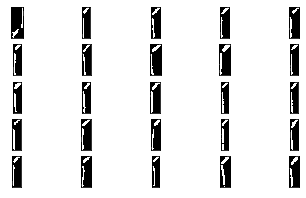

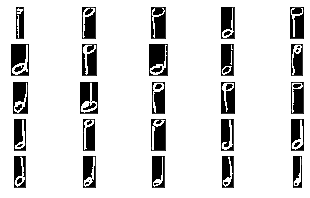

In [12]:
show_masks(qn_images[:25])
show_masks(hn_images[:25])from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred, target_names=['half', 'quarter']))

In [19]:
from skimage.transform import resize

height = 160
width = 40

qn_resized = [resize(qn, (height, width)) for qn in qn_images]
hn_resized = [resize(hn, (height, width)) for hn in hn_images]

# And re-binarize, to compensate for interpolation effects
for qn in qn_resized:
    qn[qn > 0] = 1
for hn in hn_resized:
    hn[hn > 0] = 1

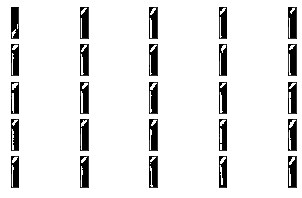

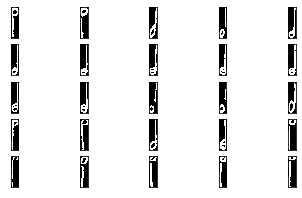

In [20]:
show_masks(qn_resized[:25])
show_masks(hn_resized[-25:])

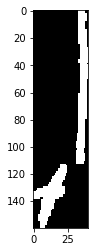

In [21]:
show_mask(qn_resized[0])

Classification of images

In [22]:
# Balancing both sets
# Randomly pick an equal number of quarter-notes.
n_hn = len(hn_resized)
import random
random.shuffle(qn_resized)
qn_selected = qn_resized[:n_hn]

In [23]:
Q_LABEL = 1
H_LABEL = 0

qn_labels = [Q_LABEL for _ in qn_selected]
hn_labels = [H_LABEL for _ in hn_resized]



notes = qn_selected + hn_resized
# Flatten data
notes_flattened = [n.flatten() for n in notes]
labels = qn_labels + hn_labels

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    notes_flattened, labels, test_size=0.25, random_state=42,
    stratify=labels)

In [25]:
from sklearn.neighbors import KNeighborsClassifier

K=5

# Trying the defaults first.
clf = KNeighborsClassifier(n_neighbors=K)
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [26]:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=1, n_neighbors=5, p=2,
                     weights='uniform')

In [27]:
y_test_pred = clf.predict(X_test)

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred, target_names=['half', 'quarter']))

              precision    recall  f1-score   support

        half       0.99      0.88      0.93       296
     quarter       0.89      0.99      0.94       295

    accuracy                           0.93       591
   macro avg       0.94      0.93      0.93       591
weighted avg       0.94      0.93      0.93       591

